# **Hands-On 1: Jupyter Notebook mit Beispiel aus der Radiographie**

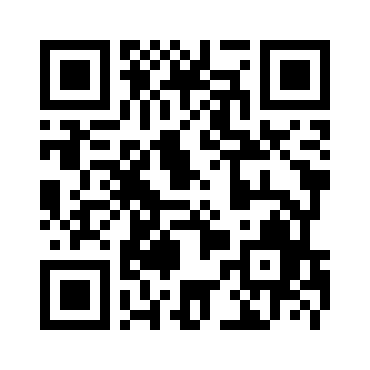

In [1]:
import qrcode
qrcode.make('https://github.com/liob/ai-winter-school/')

# Environment Setup

In this hands-on session, we will use **Jupyter Notebooks** to analyze real-world examples from radiography.

## Common Options for Running a Jupyter Notebook:
1. **Cluster Environment** – Ideal for scalable computing in research or clinical settings.
2. **On-Premise (Local Machine)** – Suitable for development and testing on your personal computer.
3. **Google Colab** - Only use with public data sets.

## Jupyter Notebook
Jupyter offers an interactive environment combining code, text, visualization, and analysis in a single document.

### How to Install:
- [Official Jupyter Installation Guide](https://jupyter.org/install)
- Or download [Anaconda](https://www.anaconda.com) and launch **Jupyter Notebook** using the **Anaconda Navigator**.

# Useful Conversion Tools for Medical Imaging:
- **dcm2niix** – Converts DICOM files to NIfTI format, commonly used in imaging workflows.
- **MRIConvert** – A tool for converting and managing medical imaging file formats. Works better for specialized 3d and 4d data sets.


# Sample Dataset: Pneumonia Detection from Chest X-rays 
> The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
> 
> Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
> 
> For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.
> 
> -- [Chest X-Ray Images (Pneumonia) Data Set](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

## Key Characteristics:
- **Total Images**: 5,863 chest X-rays (JPEG format)
- **Categories**: `NORMAL` and `PNEUMONIA`
- **Source**: Guangzhou Women and Children’s Medical Center
- **View**: Anterior-Posterior (AP) chest X-rays

You may need to install the KaggleHUB:  
```bash
!pip install kagglehub
```

In [2]:
import kagglehub

download_dir = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

## Folder Structure
The dataset is organized into three subsets commonly used in machine learning workflows:
- `train`: Used to teach the model
- `val`: Used for tuning the model during training
- `test`: Used for final model evaluation on unseen data

```
📁 download_dir
├── 📁 chest_xray
    ├── 📁 test
        ├── 📁 NORMAL
            ├── person{id}_{bacteria/virus}_{id}.jpg
        ├── 📁 PNEUMONIA
            ├── person{id}_{bacteria/virus}_{id}.jpg
    ├── 📁 train
        ├── 📁 NORMAL
            ├── person{id}_{bacteria/virus}_{id}.jpg
        ├── 📁 PNEUMONIA
            ├── person{id}_{bacteria/virus}_{id}.jpg
    ├── 📁 val
        ├── 📁 NORMAL
            ├── person{id}_{bacteria/virus}_{id}.jpg
        ├── 📁 PNEUMONIA
            ├── person{id}_{bacteria/virus}_{id}.jpg
```

## Load & Preprocess Sample Data
Before we can analyze the X-ray images, we need to load and preprocess them:

- **Resize images** to a standard shape
- **Convert to grayscale** if necessary
- **Extract labels** from folder structure
- **(Optional)** Apply data augmentation to improve model robustness

**Goal**: Transform the raw images into a clean, uniform format suitable for machine learning.

In [3]:
import os
from os import path
from glob import glob
import numpy as np
from PIL import Image
import skimage
from tqdm.notebook import trange, tqdm

In [4]:
def load_and_preprocess(input_folder, target_shape = [224,224], mean=0.485, std=0.229, label=''):
    result = []
    for fn in tqdm(glob(path.join(input_folder, '*.jpeg')), desc=label):
        
        # load image and resize to target shape
        img = Image.open(fn).resize(target_shape)
        
        # convert image to numpy array
        im = np.array(img, dtype=np.float32)
        
        # only process 2d images
        if not im.ndim == 2:
            continue

        # You may perform image augmentation tasks here, e.g.:
        # perform adaptive histogram equalization (AHE)
        #im = skimage.exposure.rescale_intensity(im)
        #im = skimage.exposure.equalize_adapthist(im, clip_limit=0.03)

        # we adapt the mean and std to the values of the original training set (imagenet)
        im = (im - np.mean(im) ) / np.std(im) * std + mean
        
        result.append(im)
    return np.array(result, dtype=np.float32)

train_normal    = load_and_preprocess(path.join(download_dir, 'chest_xray', 'train', 'NORMAL'),    label='train normal')
train_pneumonia = load_and_preprocess(path.join(download_dir, 'chest_xray', 'train', 'PNEUMONIA'), label='train pneumonia')
test_normal     = load_and_preprocess(path.join(download_dir, 'chest_xray', 'test', 'NORMAL'),     label='test  normal')
test_pneumonia  = load_and_preprocess(path.join(download_dir, 'chest_xray', 'test', 'PNEUMONIA'),  label='test  pneumonia')

train normal:   0%|          | 0/1341 [00:00<?, ?it/s]

train pneumonia:   0%|          | 0/3875 [00:00<?, ?it/s]

test  normal:   0%|          | 0/234 [00:00<?, ?it/s]

test  pneumonia:   0%|          | 0/390 [00:00<?, ?it/s]

## Visualize Sample Data

A visual check is a crucial step in any imaging workflow:

- Are the images loading correctly?
- Are the labels accurate?
- Are there any quality issues or artifacts?

We'll display random samples from each class (`NORMAL` and `PNEUMONIA`) to better understand the dataset and ensure everything looks correct.


In [5]:
from matplotlib import pyplot as plt

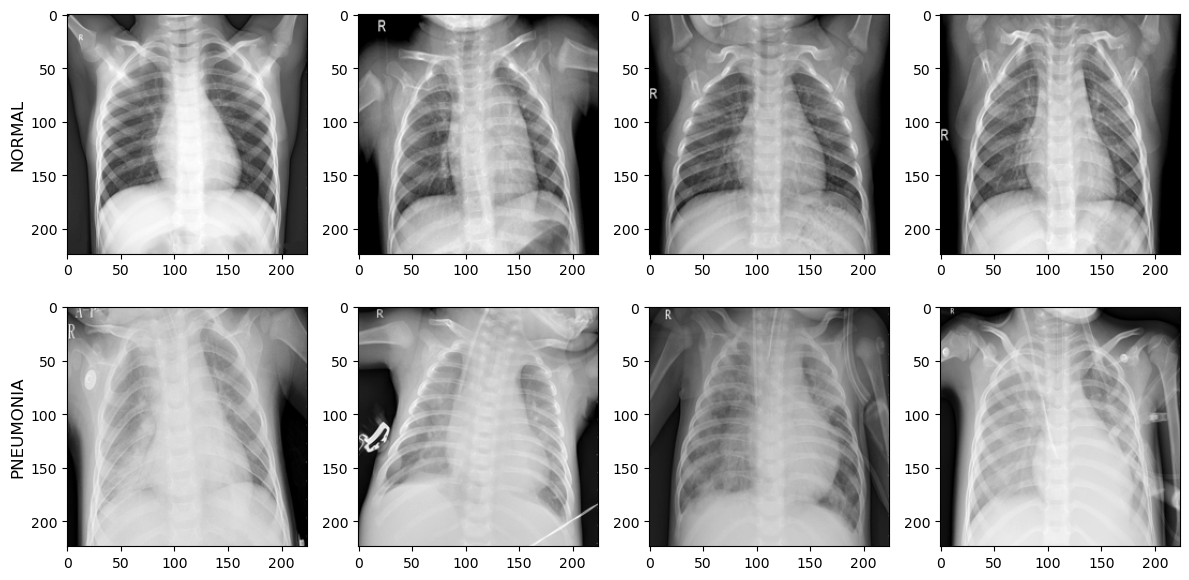

In [6]:
fig, axs = plt.subplots(2,4, figsize=(12, 6))

# plot samples without pneumonia in the first row
for ax in axs[0]:
    im_idx = index = np.random.choice(train_normal.shape[0])
    ax.imshow(train_normal[im_idx], cmap='gray')
axs[0][0].set_ylabel('NORMAL', size='large')

# plot samples pneumonia in the second row
for ax in axs[1]:
    im_idx = index = np.random.choice(train_pneumonia.shape[0])
    ax.imshow(train_pneumonia[im_idx], cmap='gray')
axs[1][0].set_ylabel('PNEUMONIA', size='large')

fig.tight_layout()

# Transfer Learning & Fine-Tuning

Medical image datasets are often small and imbalanced, which makes training a deep neural network from scratch challenging and prone to overfitting.

To address this, we use **transfer learning** – a powerful technique where we **leverage a model that has already been trained on a large dataset**, such as ImageNet, and adapt it to our specific task.

## What is Transfer Learning?
- Instead of training a model from scratch, we **reuse the convolutional layers** of a pre-trained network (in our example a [Resnet50] modell).
- These layers have already learned to detect **general patterns** like edges, textures, and shapes that are useful across many image domains – including radiography.

## What is Fine-Tuning?
- We **replace the final classification layers** of the pre-trained model with new layers tailored to our task (e.g., binary classification: Pneumonia vs. Normal).
- We can:
  - **Freeze** the early layers (to retain general features), and
  - **Fine-tune** the deeper layers (to adapt to our specific dataset).

## Why use it?
- **Faster convergence** (training requires fewer epochs)
- **Better performance** with limited data
- **Reduced computational cost**

## ImageNet
The ResNet50 model in this exampke has been pretrained on the [ImageNet] dataset, a large-scale collection of over **14 million images** across more than **1,000 categories**.

![training loss](../figures/transfer_learning_scheme.png)

In this notebook, we’ll use a pre-trained model and fine-tune it to classify chest X-ray images into two categories: `NORMAL` and `PNEUMONIA`.

[Resnet50]: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
[ImageNet]: https://www.image-net.org/

In [7]:
import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from lightning.pytorch import LightningModule, Trainer

# Working with PyTorch Dataset & DataLoader

In machine learning projects, especially with image data, we often need to:
- Load data from disk
- Apply preprocessing or augmentation
- Organize it into batches for training
- Shuffle it and iterate over it efficiently

PyTorch provides two powerful tools to handle this:


## `torch.utils.data.Dataset`

A custom `Dataset` class allows us to define **how to access and transform our data**.

We implement two main methods:
- `__len__()` – returns the number of samples
- `__getitem__(idx)` – loads and returns a single sample (e.g., an image and its label)

This abstraction allows us to:
- Read data from different formats (folders, CSVs, DICOM, NIfTI, etc.)
- Apply transformations like resizing, normalization, or augmentation on-the-fly
- Keep the data-loading logic clean and reusable


## `torch.utils.data.DataLoader`

Once we have a `Dataset`, we use a `DataLoader` to:
- Split the data into **mini-batches**
- Shuffle the data during training (to avoid learning order bias)
- Load the data in **parallel** using multiple worker threads for speed

With just a few lines of code, the `DataLoader` lets us efficiently stream data to our model during training and evaluation.


## Why is this important?

- Radiology images can be large and stored in various formats.
- Efficient and flexible data loading is key for performance.
- Using `Dataset` + `DataLoader` separates **data handling** from **model logic**, making your code cleaner and more modular.

In this notebook, we’ll define a custom `ChestXrayDataset` and use a `DataLoader` to feed the images into our model during training and evaluation.


In [8]:
class Dataset(data.Dataset):
    def __init__(self, dx, dy):
        self.dx = dx
        self.dy = dy

    def __len__(self):
        return len(self.dx)

    def __getitem__(self, index):
        x, y = self.dx[index], self.dy[index]
        return x, y

In [9]:
# concat normal and pneumonia
X_train = np.vstack([train_normal, train_pneumonia])
# reshape B,H,W to B,C,H,W
X_train = np.expand_dims(X_train, axis=1)

Y_train = np.array(len(train_normal) * [0] + len(train_pneumonia) * [1])
# perform onehot encoding
#Y_train = np.eye(np.max(Y_train) + 1)[Y_train]

# now the same for the test set
X_test = np.vstack([test_normal, test_pneumonia])
X_test = np.expand_dims(X_test, axis=1)
Y_test = np.array(len(test_normal) * [0] + len(test_pneumonia) * [1])
#Y_test = np.eye(np.max(Y_test) + 1)[Y_test]

d_train = Dataset(X_train, Y_train)
d_test =  Dataset(X_test,  Y_test)
d_params = {'batch_size': 12,
            'num_workers': 1,
            'pin_memory': True,
            'persistent_workers': True,
            }
df_train = data.DataLoader(d_train, shuffle=True,  **d_params)
df_test  = data.DataLoader(d_test,  shuffle=False,  **d_params)

print('X Train:', X_train.shape)
print('Y Train:', Y_train.shape)
print('X Test:', X_test.shape)
print('Y Test:', Y_test.shape)

X Train: (4933, 1, 224, 224)
Y Train: (4933,)
X Test: (624, 1, 224, 224)
Y Test: (624,)


# Setting Up the ImagenetTransferLearning Class

To simplify our workflow and make the code modular and reusable, we wrap our model logic inside a custom class called `ImagenetTransferLearning`.

This class handles the setup of a **pre-trained ImageNet model** (Resnet50 in our usecase) and adapts it for our specific task: **binary classification** (Pneumonia vs. Normal).


## What the Class Does

- **Loads a Pre-Trained Model**  
  We use a model trained on ImageNet (millions of natural images) as a starting point. This model has already learned to detect general visual features.

- **Freezes the Base Layers**  
  In transfer learning, we often freeze the early layers of the model so they don’t get updated during training. These layers capture low-level patterns (edges, textures) that are useful across tasks.

- **Adapts for Grayscale Input**  
  ImageNet models expect **3-channel RGB input**, but chest X-rays are **grayscale images with only 1 channel**.  
  To handle this mismatch, we modify the model's first convolutional layer:
  - Replace the input layer (`Conv2d`) to accept a **single channel** instead of three.
  - Keep the weights compatible by either:
    - Averaging the weights across the 3 original channels (this is what we do), or
    - Reinitializing the layer while keeping the rest of the model intact.

- **Replaces the Classifier Head**  
  We replace the original final layers with a new head suitable for our task:
  - In our case: a small fully connected layer for **2 output classes**.

- **Supports Fine-Tuning (Optional)**  
  If we want, we can unfreeze more layers to fine-tune the model on our specific dataset. This is helpful when we have enough data or the domain is very different from ImageNet.

In [10]:
class ImagenetTransferLearning(LightningModule):
    def __init__(self, num_target_classes=2):
        super().__init__()

        # load the pretrained ResNet-50 model
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # modify the number of input channels from 3 to 1
        original_weights = self.model.conv1.weight.data
        new_conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        new_conv1.weight.data = original_weights.mean(dim=1, keepdim=True)
        self.model.conv1 = new_conv1

        # freeze all layers in the feature extractor
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the first convolutional layer
        for param in self.model.conv1.parameters():
            param.requires_grad = True

        # replace the classifier (fully connected layer)
        num_filters = self.model.fc.in_features
        self.model.fc = nn.Linear(num_filters, num_target_classes)

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return {"val_loss": loss}
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [11]:
model = ImagenetTransferLearning()
trainer = Trainer(max_epochs=1,
                  limit_train_batches=100,
                  limit_test_batches=10,
                  check_val_every_n_epoch=1)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model,
           train_dataloaders=df_train,
           val_dataloaders=df_test)

2025-04-09 19:10:29.376282: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 19:10:29.611345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744225829.700830  398911 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744225829.729533  398911 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744225829.909947  398911 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jovyan/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/home/jovyan/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


# Visualize Training Progress with Tensorboard

To monitor how well our model is learning, we’ll use **TensorBoard**, a powerful visualization toolkit that helps track training metrics in real-time.

## Why Use TensorBoard?

TensorBoard provides:
- Immediate feedback during training
- Insight into whether the model is **overfitting**, **underfitting**, or progressing well
- A way to compare different runs and model configurations

## Install TensorBoard
```
!pip install tensorflow tensorboard
```

## Run TensorBoard
```
tensorboard --logdir=lightning_logs
```

## Training Loss
![training loss](../figures/image_classification_radiographs_pneumonia_transfer_learning_training_loss.png)

## Validation Loss
![validation loss](../figures/image_classification_radiographs_pneumonia_transfer_learning_val_loss.png)

# Overfitting vs. Underfitting

When training deep learning models, especially with medical images like chest X-rays, we must be careful to balance learning performance — avoiding both **overfitting** and **underfitting**.

- **Overfitting** occurs when the model learns the training data *too well*, including noise or irrelevant patterns. It performs well on training data but poorly on unseen (validation/test) data.
- **Underfitting** happens when the model is *too simple* to capture the underlying patterns in the data. It performs poorly on both training and validation sets.

## How to Prevent Overfitting

- **Data augmentation!**: Randomly transform input images (flip, rotate, crop) to help the model generalize.
- **Use regularization** techniques:
  - `Dropout` layers
  - `Weight decay` (L2 regularization)
- **Early stopping**: Stop training when validation performance stops improving.
- **Transfer learning**: Using pre-trained models reduces the risk of overfitting on small datasets.
- **Cross-validation**: Validate on multiple subsets of the data for more robust performance estimates.

## How to Prevent Underfitting

- Use a **deeper model** if your current model is too simple.
- **Reduce regularization** if it’s too aggressive.
- **Train longer**: Some models simply need more epochs to converge.
- Make sure your **data preprocessing is not too destructive** (e.g., overly compressed or resized images).